In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import _load_autoencoder, _load_masker

In [ ]:
autoencoder = _load_autoencoder()
masker = _load_masker()

# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

In [54]:
X = neuro_vectors[pd.Series(pmids).isin(test)]
X = X.to("cuda")
with torch.no_grad():
    X_re = autoencoder.to("cuda")(X)

X = X.to("cpu")
X_re = X_re.to("cpu")

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [56]:
fpr, tpr, _ = roc_curve(
    X.numpy().reshape(-1) > 0.5,
    torch.sigmoid(X_re).numpy().reshape(-1)
)
roc_auc = auc(fpr, tpr)

In [ ]:


def bernoulli_bce(y, p, eps=1e-7):
    """Elementwise Bernoulli negative log-likelihood (cross-entropy), in nats."""
    p = np.clip(p, eps, 1 - eps)
    y = np.clip(y, 0.0, 1.0)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

def eval_recon_bpp(y_true, logits, *, baseline="per_pixel", eps=1e-7):
    """
    y_true: (N, D) floats in [0,1]
    logits: (N, D) raw logits from decoder (before sigmoid)

    Returns dict with:
      - bpp_model_per_image
      - bpp_base_per_image
      - delta_bpp_per_image (base - model)
      - delta_bpp_per_pixel (mean over N, in bits)  # for a skill map
    """
    y_true = np.asarray(y_true)
    logits = np.asarray(logits)
    assert y_true.shape == logits.shape, f"shape mismatch: {y_true.shape} vs {logits.shape}"
    N, D = y_true.shape

    p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)

    # Model BCE per image (mean over pixels), then to bits
    bce_model = bernoulli_bce(y_true, p, eps=eps).mean(axis=1)  # (N,)
    bpp_model = bce_model / np.log(2)

    # Baseline probabilities
    if baseline == "global":
        p0 = float(y_true.mean())
        p_base = np.full((N, D), p0, dtype=np.float64)
    elif baseline == "per_pixel":
        p0 = y_true.mean(axis=0, keepdims=True)  # (1, D)
        p_base = np.repeat(p0, repeats=N, axis=0)  # (N, D)
    else:
        raise ValueError("baseline must be 'global' or 'per_pixel'")

    bce_base = bernoulli_bce(y_true, p_base, eps=eps).mean(axis=1)  # (N,)
    bpp_base = bce_base / np.log(2)

    delta_bpp = bpp_base - bpp_model  # (N,) improvement over baseline, bits/pixel

    # Per-pixel skill map (average improvement over images)
    bce_model_px = bernoulli_bce(y_true, p, eps=eps)          # (N, D)
    bce_base_px  = bernoulli_bce(y_true, p_base, eps=eps)     # (N, D)
    delta_bpp_px = (bce_base_px - bce_model_px).mean(axis=0) / np.log(2)  # (D,)

    return dict(
        bpp_model_per_image=bpp_model,
        bpp_base_per_image=bpp_base,
        delta_bpp_per_image=delta_bpp,
        delta_bpp_per_pixel=delta_bpp_px,
        baseline=baseline,
    )

In [82]:
res = eval_recon_bpp(X, X_re, baseline="per_pixel")

delta = res["delta_bpp_per_image"]          # (N,)
bpp_base = res["bpp_base_per_image"]        # (N,)

pct = 100.0 * (delta / np.clip(bpp_base, 1e-12, None))

<positron-console-cell-82>:6: RuntimeWarning: overflow encountered in exp


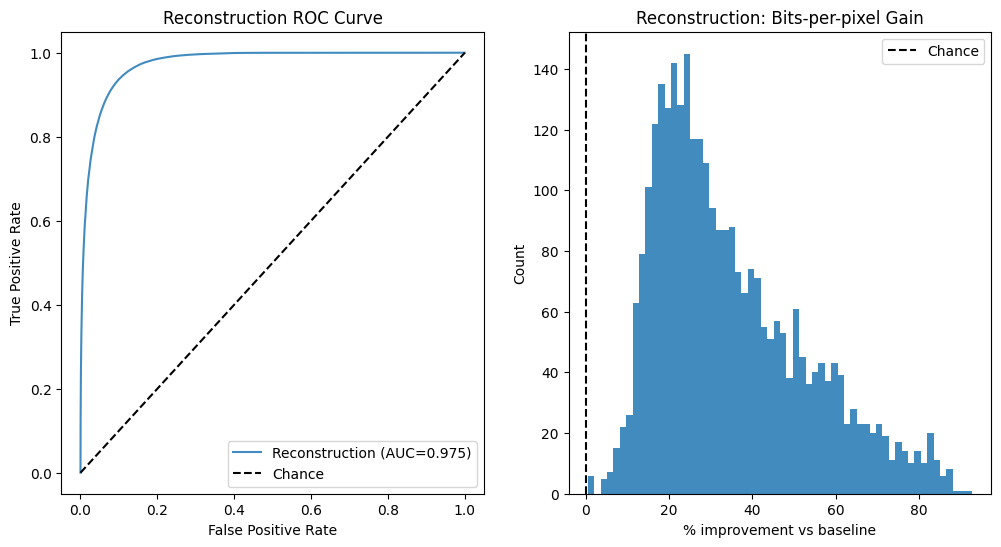

In [89]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

axes[0].plot(fpr[::1000], tpr[::1000], alpha=0.85, label=f"Reconstruction (AUC={roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], color='k', ls='--', label='Chance')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Reconstruction ROC Curve")
axes[0].legend()

axes[1].hist(pct, bins=60, alpha=0.85)
axes[1].axvline(0.0, linestyle="--", color='k', label="Chance")
axes[1].set_xlabel("% improvement vs baseline")
axes[1].set_ylabel("Count")
axes[1].set_title("Reconstruction: Bits-per-pixel Gain")
axes[1].legend()

plt.savefig(data_dir / "autoencoder_perf.png", dpi=300)